In [1]:
install.packages("caret")
install.packages("e1071")
install.packages("caTools")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("corrplot")
install.packages("grid")
install.packages("gridExtra")

Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message:
“package ‘grid’ is a base package, and should not be updated”
Installing package into ‘/home/avind/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)
library(grid)
library(lattice)
library(gridExtra)

library(caTools)
library(caret)
library(e1071)

library(dplyr)
library(corrplot)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.92 loaded



In [3]:
options(repr.plot.width = 10, repr.plot.height = 10)

In [4]:
dataset <- read.csv("./dataset.csv", header = TRUE)

In [5]:
# Basic summarizations
dim(dataset)
head(dataset)

[1] 1470   35

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


In [6]:
# Removing obvious useless columns
dataset$EmployeeNumber <- NULL
dataset$StandardHours <- NULL
dataset$Over18 <- NULL
dataset$EmployeeCount <- NULL

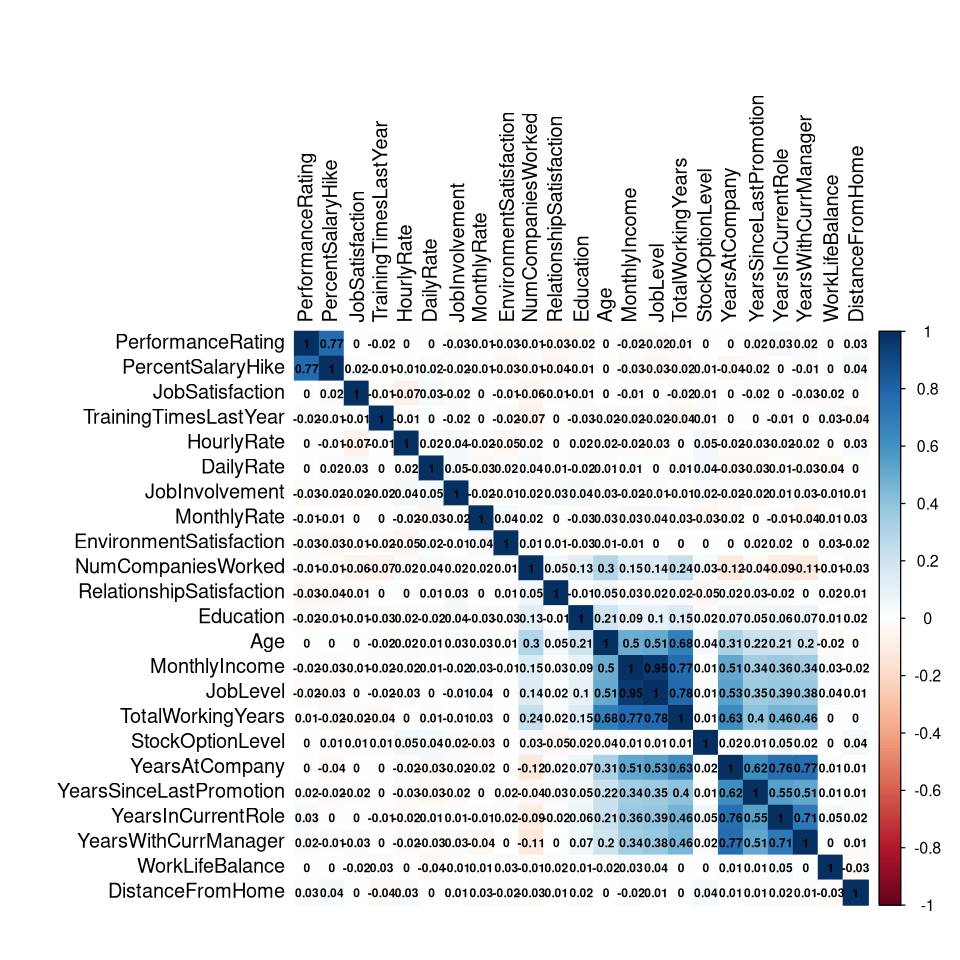

In [7]:
corr_dataset <- dataset

numeric_data <- corr_dataset %>%
  select_if(is.numeric)

cor_matrix <- cor(numeric_data)

options(repr.plot.width = 8, repr.plot.height = 8)
corrplot(cor_matrix, method = "color", order="AOE", addCoef.col = "black", tl.col = "black", tl.srt = 90, number.cex = 0.6)

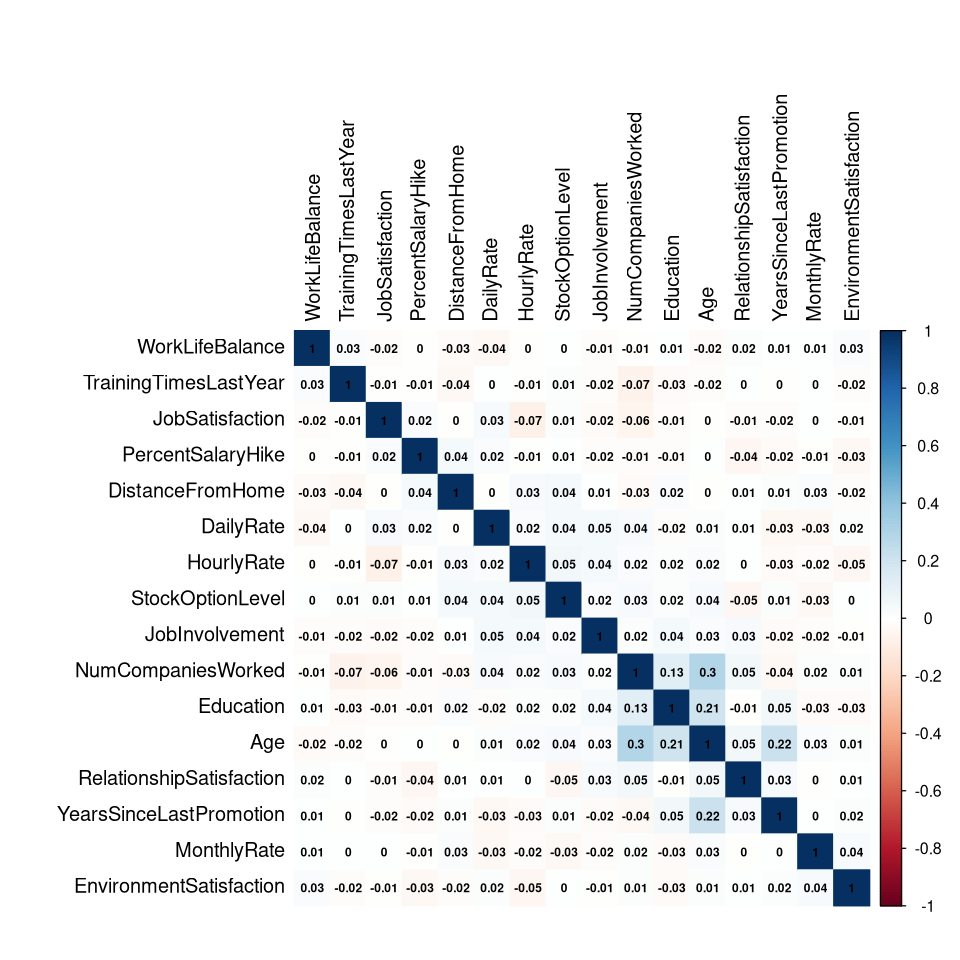

In [8]:
filtered_dataset <- corr_dataset

filtered_dataset$TotalWorkingYears <- NULL
filtered_dataset$MonthlyIncome <- NULL
filtered_dataset$JobLevel <- NULL
filtered_dataset$YearsWithCurrManager <- NULL
filtered_dataset$YearsAtCompany <- NULL
filtered_dataset$YearsInCurrentRole <- NULL
filtered_dataset$PerformanceRating <- NULL

numeric_data <- filtered_dataset %>%
  select_if(is.numeric)

cor_matrix <- cor(numeric_data)

par(mar = c(2, 2, 2, 2))  # Adjust the margins if needed
options(repr.plot.width = 8, repr.plot.height = 8)
corrplot(cor_matrix, method = "color", order="AOE", addCoef.col = "black", tl.col = "black", tl.srt = 90, number.cex = 0.6)

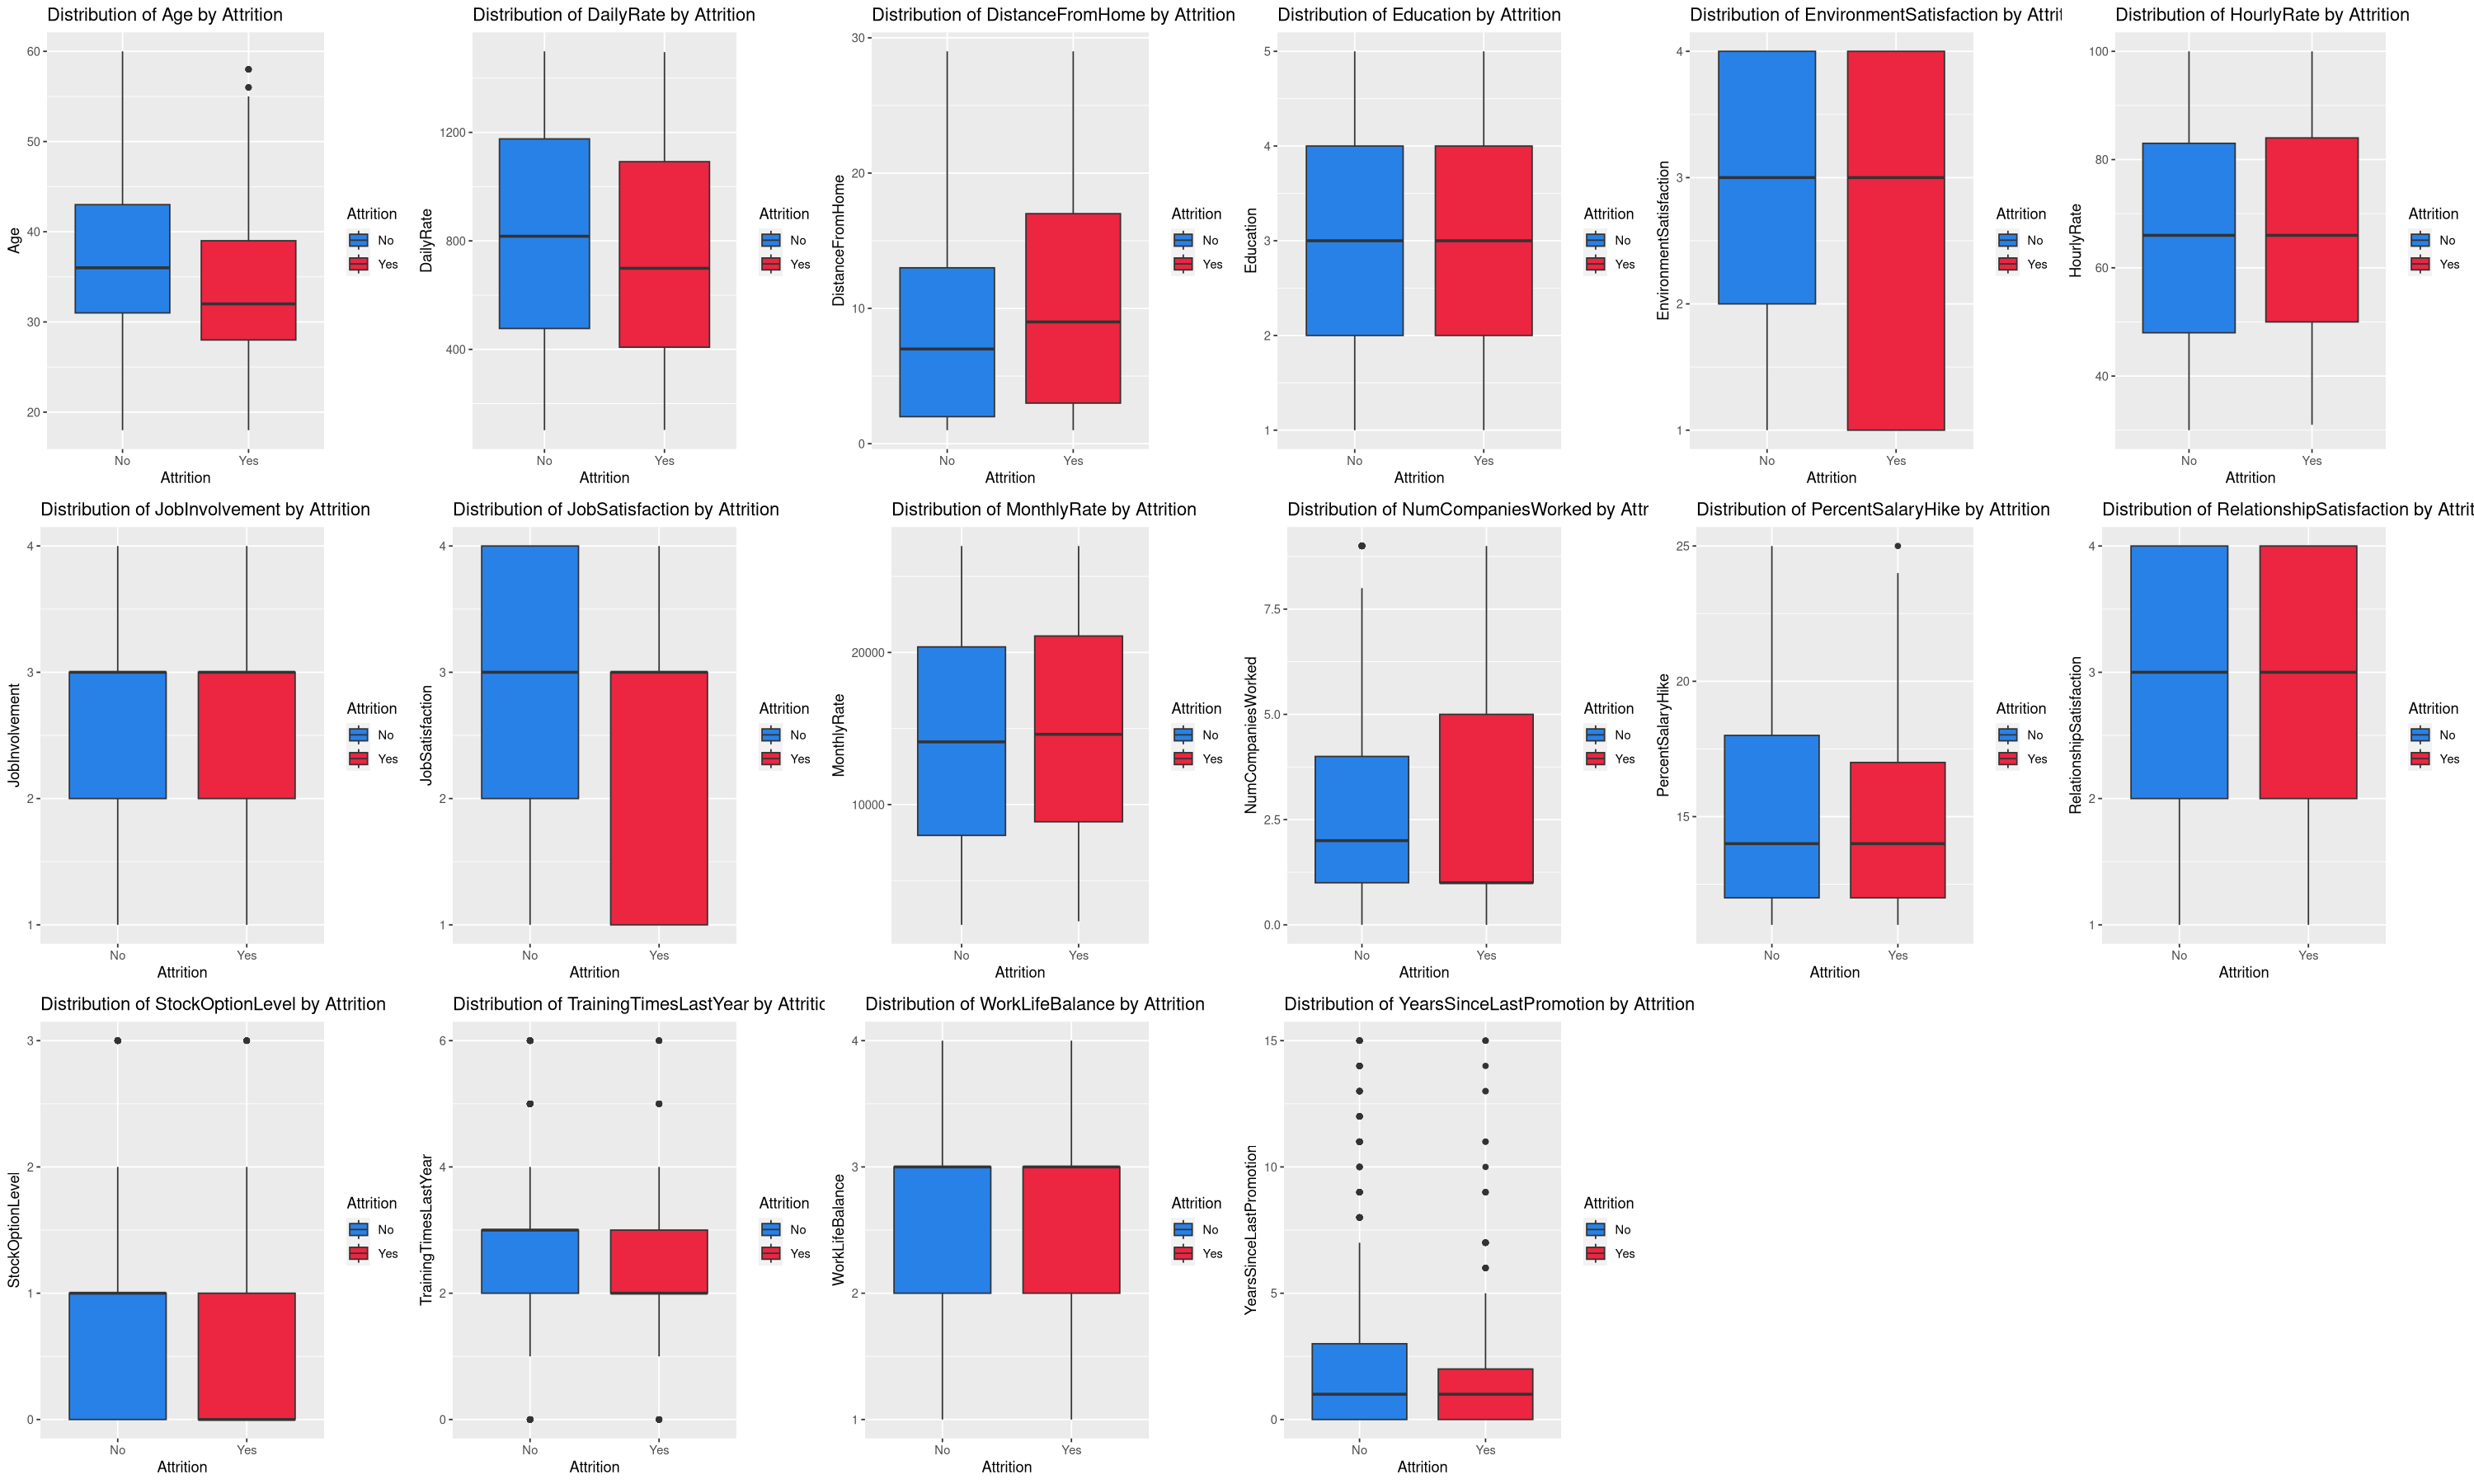

In [9]:
plot_data <- filtered_dataset
plot_list <- list()

for (feature in names(plot_data)){
        if (is.numeric(plot_data[[feature]])){
                plot_list[[feature]] <- ggplot(plot_data, aes(x = Attrition, y = !!sym(feature), fill = Attrition)) + 
                geom_boxplot() +
                scale_fill_manual(values = c("Yes" = "#ec2540", "No" = "#2881e7")) +
                ggtitle(paste("Distribution of ", feature, " by Attrition", sep = ""))
        }
}

options(repr.plot.width = 25, repr.plot.height = 15)
do.call(grid.arrange, c(plot_list, ncol = 6))

[1] "Dimensions before outlier filteration: 1470 24"
[1] "Dimensions after outlier filteration: 1444 24"


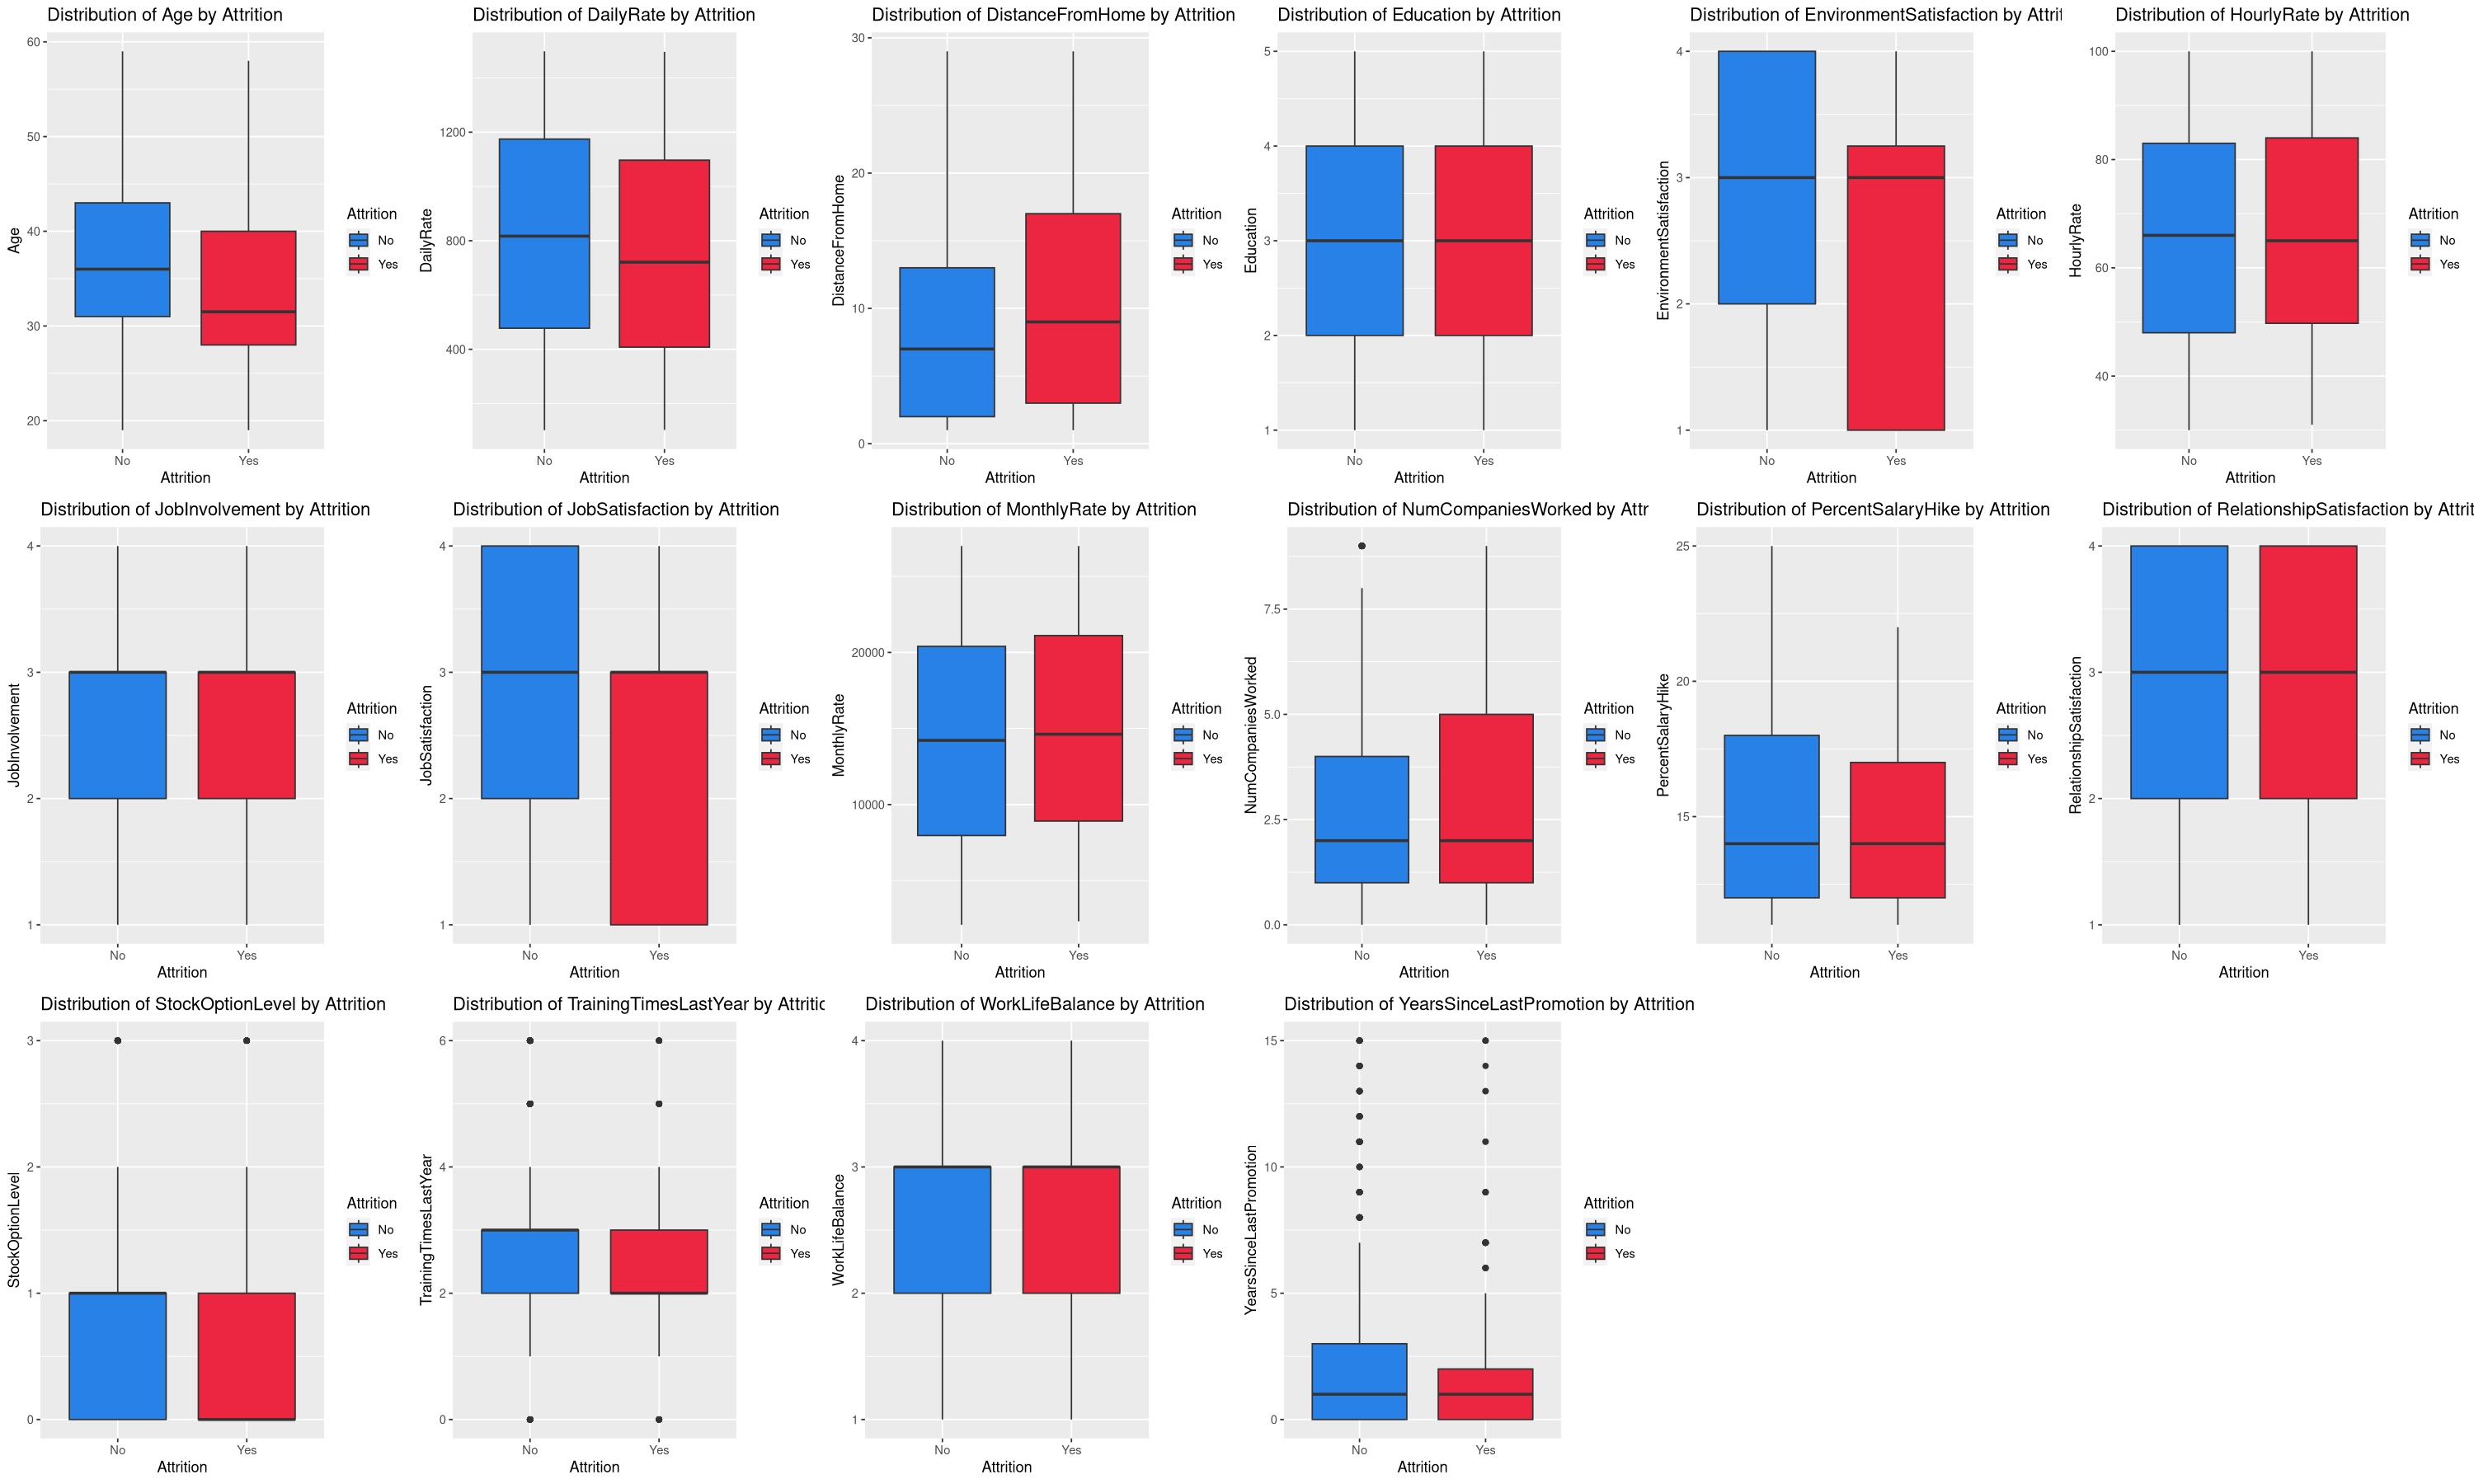

In [10]:
# Filter outliers

filter_outliers <- function(data, feature, low_bound = -1, high_bound = 1, rm_attrition_status = "both"){
        if (low_bound != -1 && high_bound != -1){
                if (rm_attrition_status == "both"){
                        return (data[data[, feature] > low_bound & data[, feature] < high_bound, ])
                } else {
                        return (data[(data[, feature] > low_bound & data[, feature] < high_bound & data$Attrition == rm_attrition_status) | data$Attrition != rm_attrition_status, ])
                }
        } else {
                outliers <- boxplot(data[, feature], plot=FALSE)$out
                return (data[!data[, feature] %in% outliers, ])
        }
}

plot_data <- filtered_dataset
plot_list <- list()

curr_dim <- dim(plot_data)
print(paste("Dimensions before outlier filteration:", curr_dim[1], curr_dim[2]))

plot_data <- filter_outliers(plot_data, "Age", low_bound = 18, high_bound = 60)
plot_data <- filter_outliers(plot_data, "PercentSalaryHike", low_bound = 10, high_bound = 23, rm_attrition_status = "Yes")

for (feature in names(plot_data)){
        if (is.numeric(plot_data[[feature]])){
                plot_list[[feature]] <- ggplot(plot_data, aes(x = Attrition, y = !!sym(feature), fill = Attrition)) + 
                geom_boxplot() +
                scale_fill_manual(values = c("Yes" = "#ec2540", "No" = "#2881e7")) +
                ggtitle(paste("Distribution of ", feature, " by Attrition", sep = ""))
        }
}

curr_dim <- dim(plot_data)
print(paste("Dimensions after outlier filteration:", curr_dim[1], curr_dim[2]))
options(repr.plot.width = 25, repr.plot.height = 15)
do.call(grid.arrange, c(plot_list, ncol = 6))

filtered_dataset <- plot_data

## Naive Bayes classifier

In [11]:
# Splitting the dataset into the Training set and Test set
nb_dataset <- filtered_dataset
set.seed(100)
split_ratio <- sample.split(nb_dataset, SplitRatio = 0.7)

training_set <-  subset(nb_dataset, split_ratio=="TRUE")
testing_set <- subset(nb_dataset, split_ratio=="FALSE")

In [12]:
# Training the Naive Bayes model and predicting the Test set results
nb_model <- naiveBayes(Attrition~., data=training_set)

prediction_results <- predict(nb_model, newdata=testing_set)

matrix <- table(testing_set$Attrition, prediction_results)
cm <- confusionMatrix(matrix)

print(cm)

Confusion Matrix and Statistics

     prediction_results
       No Yes
  No  405   8
  Yes  44  23
                                         
               Accuracy : 0.8917         
                 95% CI : (0.8604, 0.918)
    No Information Rate : 0.9354         
    P-Value [Acc > NIR] : 0.9999         
                                         
                  Kappa : 0.418          
                                         
 Mcnemar's Test P-Value : 1.212e-06      
                                         
            Sensitivity : 0.9020         
            Specificity : 0.7419         
         Pos Pred Value : 0.9806         
         Neg Pred Value : 0.3433         
             Prevalence : 0.9354         
         Detection Rate : 0.8438         
   Detection Prevalence : 0.8604         
      Balanced Accuracy : 0.8220         
                                         
       'Positive' Class : No             
                                         


In [13]:
# Accuracy automator

nb_dataset <- filtered_dataset

test_seeds <- seq(1, 100)

seed_len <- length(test_seeds)
overall_accuracy <- 0
max_accuracy <- 0
min_accuracy <- -1

for (curr_seed in test_seeds){
    set.seed(curr_seed)
    
    split_ratio <- sample.split(nb_dataset, SplitRatio = 0.7)

    training_set <-  subset(nb_dataset, split_ratio=="TRUE")
    testing_set <- subset(nb_dataset, split_ratio=="FALSE")
    
    nb_model <- naiveBayes(Attrition~., data=training_set)

    prediction_results <- predict(nb_model, newdata=testing_set)

    matrix <- table(testing_set$Attrition, prediction_results)
    cm <- confusionMatrix(matrix)
    curr_accuracy <- cm$overall["Accuracy"]
    
    if (min_accuracy < 0 | min_accuracy > curr_accuracy){
        min_accuracy <- curr_accuracy
    }
    
    if (max_accuracy < curr_accuracy){
        max_accuracy <- curr_accuracy
    }
    
    overall_accuracy <- overall_accuracy + curr_accuracy
}
overall_accuracy <- (overall_accuracy/seed_len)*100
max_accuracy <- max_accuracy * 100
min_accuracy <- min_accuracy * 100

print(paste("Overall Accuracy:", sprintf("%.2f%%", overall_accuracy)))
print(paste("Accuracy range: (", sprintf("%.2f%%", min_accuracy), "-", sprintf("%.2f%%", max_accuracy), ")"))

[1] "Overall Accuracy: 86.73%"
[1] "Accuracy range: ( 83.78% - 90.02% )"
